In [1]:
import bb
from threading import Thread
import queue
import system_model
import numpy as np
import bbrbdl
import control
import linear_controller
from bb_interactive import *
%matplotlib inline
from matplotlib import pyplot as plt

BB = begin()
M = bbrbdl.BBModel(bbrbdl.BBParams())

Masses:  0.6361725123519333 1


/home/soa/bb/bbrbdl.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  body = rbdl.Body.fromMassComInertia(roller_mass, np.array([0.,0.,0.]), np.diag([1, 1, roller_moi]))
/home/soa/bb/bbrbdl.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  body = rbdl.Body.fromMassComInertia(board_mass, np.array([0, 0.5, 0]), np.eye(3)*.1)
/home/soa/bb/bbrbdl.py:66: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  body = rbdl.Body.fromMassComInertia(body_mass, np.array([0, 0., 0]), np.eye(3) * body_moi)


In [2]:
ns = M.model.q_size + M.model.qdot_size
s = system_model.Simulation(M.model,np.zeros(ns))
X = s.sim(5)

lsa = system_model.LinearSystemApproximator()
#u0 = np.array([0,0,-1,1])*3*9.81*.1
u0 = np.zeros(ns/2)
ss = lsa.calculate(M.model, s.x0[:ns/2], s.x0[ns/2:], u0 )

css = control.ss(ss.A, ss.B, np.eye(ns), np.zeros([ns,ns/2]))

[K,S,E] = control.lqr(css, np.diag(np.ones(ns)), np.eye(ns/2))
P = linear_controller.LinearController( K, np.zeros(ns),u0)
s.control = P
s.x0[0] = -.05
s.reset()
X = s.simUntil()

BB.show_state(X)

/home/soa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/soa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/soa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/soa/anaconda3/lib/python3.5/site-packages/numpy/lib/twodim_base.py:233: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m = zeros((N, M), dtype=dtype)
/home/soa/anaconda3/lib/python3.5/site-packages/numpy/lib/twodim_base.py:240: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  m[:M-k].flat[i::M+1

In [3]:
s = system_model.Simulation(M.model,np.zeros(ns))
css = control.ss(ss.A, ss.B, np.eye(ns), np.zeros([ns,ns/2]))
#delay = control.pade(.05, 5)
#css = control.series(css, delay)

css.B = css.B[:,2:]
css.A = np.delete(css.A, 2, 0)
css.A = np.delete(css.A, 2, 1)
css.B = np.delete(css.B, 2, 0)
css.C = np.delete(css.C, 2, 0)
css.C = np.delete(css.C, 2, 1)
css.D = np.delete(css.D, 2, 0)

[w,v] = np.linalg.eig(ss.A)
V = np.real(v)
D = (np.real(w)+np.abs(np.real(w)))*10+1
#Q = V.dot(np.diag(D)).dot(np.transpose(V))

Q = np.diag([1, 1, 1, 1, 10])

[K,S,E] = control.lqr(css, Q, 100*np.eye(css.B.shape[1]))
K = np.r_[np.zeros([2,ns]),np.insert(K,2,0,1)]#,np.zeros([1,ns])]
print(K)

P = linear_controller.LinearController( K, q0 = np.array([0, 0, 0, 0, 0, 0]), u0 = u0)
P = linear_controller.ControlDelay(P, 0)
D = np.zeros(ns/2)
D[0] = 1
D[1] = 1
P = linear_controller.AddControl(P, linear_controller.Disturbance(150, 300, D))
s.control = P
s.x0[0] = 0
s.x0[1] = 0
s.reset()
print(s.x0)
X = s.simUntil(tMax = 20, tMin = 2)
BB.show_state(X)


/home/soa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/soa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/soa/bb/system_model.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  norm = np.linalg.norm(x[vel_idx:])


[[  0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.        ]
 [ 43.20457921  36.89175466   0.          10.27993658   8.64147452
   -0.31622777]]
[ 0.  0.  0.  0.  0.  0.]


[[  0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.        ]
 [ 43.20457921  36.89175466   0.          10.27993658   8.64147452
   -0.31622777]]


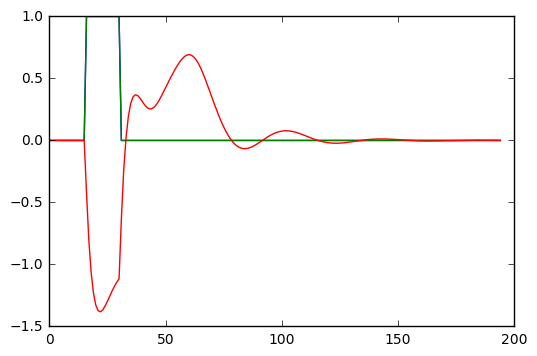

In [4]:
plt.plot(np.transpose(s.T[:,:]))
print(K)
plt.show()



In [5]:
#sensor time delays

css = control.ss(ss.A, ss.B, np.eye(ns), np.zeros([ns,ns/2]))
dA = np.diag(np.ones(4),1)
dB = np.transpose(np.matrix([0,0,0,0,1]))
dC = np.matrix([1,0,0,0,0])
dD = np.zeros(1)
print(dA,dB,dC,dD)
delay = control.ss(dA,dB,dC,dD,.05/5)
css = control.series(css, delay)
print(css)

/home/soa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.]] [[0]
 [0]
 [0]
 [0]
 [1]] [[1 0 0 0 0]] [ 0.]


ValueError: C = A * B: A has 1 column(s) (input(s)), but B has 8 row(s)
(output(s)).

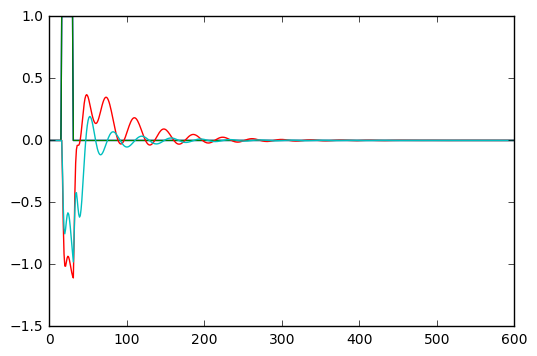

In [6]:
[w,v] = np.linalg.eig(ss.A)
np.real(w)+np.abs(np.real(w))+1
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(np.transpose(s.T))
plt.show()

In [24]:
def show_mode(x, amp = 1, n = 120):
    X = np.zeros([x.size, n])
    X[:,0] = x*.1
    for i in range(1,n):        
        X[:,i] = X[:,i-1] + 1/30. * ss.A.dot(X[:,i-1])
    return X
print(w,v.shape)
BB.show_state(show_mode(np.real(v[:,0])))

[ -1.28785871e-14 +7.89868833e+00j  -1.28785871e-14 -7.89868833e+00j
   5.46257231e+00 +0.00000000e+00j  -5.46257231e+00 +0.00000000e+00j
   4.44089210e-15 +4.88681973e+00j   4.44089210e-15 -4.88681973e+00j
  -1.09280802e-16 +6.48956474e-13j  -1.09280802e-16 -6.48956474e-13j] (8, 8)


In [ ]:
s.control.computeU(s.x0,s.tau)
s.tau
s.reset()
s.sim(10/30.)

P = linear_controller.LinearController( K, np.zeros(4), np.zeros(2))
s.control = P
s.x0 = np.asarray([.05,0,0,0])
s.reset()
BB.show_state(s.simUntil())


In [ ]:
s.X[1,:]
np.linalg.norm(s.X[:,20])
system_model.stateLimits(1e-3,1e2)(s.X[:,20])

if True and not 